In [302]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import warnings
warnings.simplefilter('ignore')

data = pd.read_csv('yellow_tripdata_2018-06.csv', usecols=['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'fare_amount', 'tip_amount', 'total_amount'])
    
locs_df = pd.read_csv('taxi _zone_lookup.csv')

locs = locs_df[['LocationID', 'Borough']]

data = data.merge(locs, left_on='PULocationID', right_on='LocationID').merge(locs, left_on='DOLocationID', right_on='LocationID', suffixes = ('_PU', '_DO'))

data = data.drop(['LocationID_PU', 'LocationID_DO'], axis = 1)

data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])

data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

data['trip_duration_seconds'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds()

data['day_of_week'] = data['tpep_dropoff_datetime'].dt.day_name()

data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,Borough_PU,Borough_DO,trip_duration_seconds,day_of_week
0,1,2018-06-01 00:15:40,2018-06-01 00:16:46,145,145,3.0,0.0,4.3,Queens,Queens,66.0,Friday
1,1,2018-06-01 00:51:25,2018-06-01 00:51:29,145,145,2.5,0.0,3.8,Queens,Queens,4.0,Friday
2,1,2018-06-01 00:55:06,2018-06-01 00:55:10,145,145,2.5,0.0,3.8,Queens,Queens,4.0,Friday
3,2,2018-06-01 00:35:11,2018-06-01 00:35:16,145,145,52.0,0.0,52.8,Queens,Queens,5.0,Friday
4,1,2018-06-01 01:35:00,2018-06-01 01:35:59,145,145,2.5,0.0,3.8,Queens,Queens,59.0,Friday


# Average trip duration during the week

In [303]:
mean_duration = data.groupby(['day_of_week'])[['trip_duration_seconds']].mean() // 60

right_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

mean_duration = mean_duration.groupby(['day_of_week']).sum().reindex(right_order) 

trace1 = go.Bar(x = mean_duration.index, y = mean_duration['trip_duration_seconds'])

fig = go.Figure([trace1], layout=layout)

layout = {'title': 'Average trip duration during the week', 'xaxis': {'title': 'Day Of Week'}, 'yaxis': {'title': 'Minutes'}}

iplot(fig, show_link=False)

In [306]:
far_df = data[(data['Borough_DO'] == 'Unknown') | (data['Borough_PU'] == 'Unknown') |  (data['Borough_DO'] == 'EWR') | (data['Borough_PU'] == 'EWR')].groupby(['day_of_week'])[['trip_duration_seconds']].count()/1000

short_df = data[data['trip_duration_seconds'] < 64800].groupby(['day_of_week'])[['trip_duration_seconds']].count() / 10**6

far_df = far_df.groupby(['day_of_week']).sum().reindex(right_order)

short_df = short_df.groupby(['day_of_week']).sum().reindex(right_order) 

trace2 = go.Bar(x = long_df.index, y = long_df['trip_duration_seconds'], name = 'Trips to far locations, thousands')

trace3 = go.Bar(x = all_df.index, y = all_df['trip_duration_seconds'], name = 'Number of short trips, millions')

fig = go.Figure([trace2, trace3], layout=layout)

layout = {'title': 'Trips to airport or outside the city and number of trips', 'xaxis': {'title': 'Day Of Week'}, 'yaxis': {'title': 'Number of trips'}}

iplot(fig, show_link=False)

# 2

In [307]:
data = data[(data['Borough_DO'] != 'Unknown') & (data['Borough_PU'] != 'Unknown')]

columns = ['Borough_PU', 'Borough_DO']

temp_df = data[data['Borough_PU'] != data['Borough_DO']]

temp_df[columns] = np.sort(temp_df[columns].values, axis=1)

boroughs_mean = temp_df.groupby(columns, as_index = False)[['fare_amount']] \
                         .mean() \
                         .sort_values(['fare_amount'], ascending = False)

top10 = boroughs_mean[:10]

trace = go.Scatter(x = top10['Borough_PU']+' - '+top10['Borough_DO'], y = top10['fare_amount'])

layout = {'title': 'TOP 10 borough pairs with max average trip fare', 'yaxis': {'title': 'trip fare'}}

iplot (go.Figure([trace], layout=layout), show_link=False)

# 3

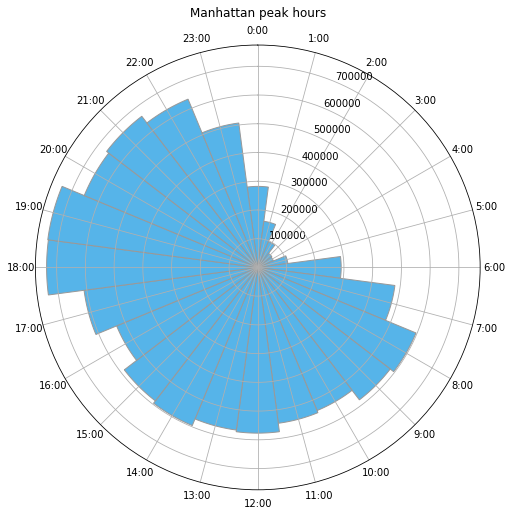

In [308]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    width = (2*np.pi) / N
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

temp_df = data

temp_df['PU_hour'] = temp_df['tpep_pickup_datetime'].dt.hour

temp_df['DO_hour'] =temp_df['tpep_dropoff_datetime'].dt.hour

start = temp_df[(temp_df['Borough_PU'] == 'Manhattan') & ~(temp_df['day_of_week'].isin(['Saturday', 'Sunday']))].groupby('PU_hour')['PU_hour'].count()
end = temp_df[(temp_df['Borough_DO'] == 'Manhattan') & ~(temp_df['day_of_week'].isin(['Saturday', 'Sunday']))].groupby('DO_hour')['DO_hour'].count()

peak_hours = pd.concat([start, end], axis = 1).fillna(0)

peak_hours['Total'] = peak_hours['DO_hour'] + peak_hours['PU_hour']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,18))

ax = plt.subplot(2,1,1, polar=True)

radii = np.array(peak_hours['Total'].tolist(), dtype="int64")

title = "Manhattan peak hours"

plt_clock(ax, radii, title, "#56B4E9")

# Got an idea to that awesome visualization and some useful tips from https://chih-ling-hsu.github.io/2018/05/14/NYC#q1-which-regions-have-most-pickups-and-drop-offs

In [322]:
start[(start.index).isin([18,19,20,21,22])].sum()*3.4  # dollars


5847717.8